Анализ данных

In [145]:
import ast
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mc
import numpy as np
%matplotlib inline

import urllib
import subprocess
import datetime

days_dict = {
    1 : u'понедельник',
    2 : u'вторник',
    3 : u'среда',
    4 : u'четверг',
    5 : u'пятница',
    6 : u'суббота',
    7 : u'воскресенье',
}

# Получение стат данных пользователей из файла
def get_users_statistics(filename):
    with open(filename, 'r') as fh:
        data_raw = fh.readlines()
    
    data = {}
    i = 0
    while i < len(data_raw):
        user_id = data_raw[i].strip()
        user_stat = ast.literal_eval(data_raw[i+1].strip())
        data[user_id] = user_stat
        i += 2

    return data

# Получение распределения вероятностей работы пользователя.
# Вероятность доступа в Интернет в течении дня.
def get_probability_by_day(user, user_stat):
    daily_probability = {}
    for day in range(1,8):
        probability = {}
        s = sum([ user_stat[day][hour] for hour in range(0,24)])
        hourly_probability = {}
        for hour in range(0,24):
            hourly_probability[hour] = round((user_stat[day][hour]/float(s)), 1) 
        daily_probability[day] = hourly_probability

    return daily_probability

# Получение распределения вероятностей работы пользователя.
# Вероятность доступа в Интернет от конкретного часа суток.
def get_probability_by_hour(user, user_stat):
    daily_probability = user_stat.copy()
    for hour in range(0,24):
        s = sum( [ user_stat[day][hour] for day in range(1,8)] )
        hourly_probability = {}
        if s != 0:
            for day in range(1,8):
                daily_probability[day][hour] = round((user_stat[day][hour]/float(s)), 1)
        else:
            for day in range(1,8):
                daily_probability[day][hour] = 0
    
    return daily_probability

def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = mc.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

# Отрисовка.
# Функция отрисовки распределения запросов/вероятностей
# 1) Диаграмма распределения запросов пользователя
# 2) Диаграмма распределения вероятностей доступа в Интернет
# 
# user идентификатор пользователя
# data1 данные, в формате словаря {day : {hour : , }, }
# title Заголовок рисунка
# coeff Коэффициент объема (используется при отрисовке вероятностей для визуального удобства)
# border Коэффициент отсечения (не отрисовываются позиции с вероятностью меньше велечины коэффициента)
def show_diag(user, data1, title, coeff = 1, border = 0):
    plt.title(title + user)
    plt.xticks(range(0,24), range(0,24), rotation=0)
    plt.yticks(range(1,8), days_dict.values(), rotation=0)
#    colors = cm.rainbow(np.linspace(0, 200, 24))
#    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'b', 'purple', 'pink', 'brown', 'orange', 'teal', 'coral', 'lightblue', 'lime', 'lavender', 'turquoise', 'darkgreen', 'tan', 'salmon', 'gold', 'lightpurple', 'darkred', 'darkblue']
    for day, value in data1.iteritems():
        requests_in_hours = value.values()
    #    print day, requests_in_hours
        for h in range(0,24):
            if requests_in_hours[h] < border :
                plt.scatter(h, day, s=0)
            else:
                plt.scatter(h, day, s=requests_in_hours[h]*coeff)
    
    plt.show()

# Отрисовка количества посещений пользователя по часам в определенный день
# users_daily_statistics данные о посещениях пользователя за день, dict {hour : , }
# date дата, строка в формате YYYY-MM-DD
def show_daily_diag(user_daily_statistics, date):
    #date = '2018-01-11'
    hours = range(0,24)
    values = user_daily_statistics.values()
    
    plt.figure(figsize=(3, 8))
    
    pos = np.arange(len(values))
    
    plt.title(u'Запросы пользователя {} по часам'.format(date))
    plt.barh(pos, values)
    
    #add the numbers to the side of each bar
    for p, c, ch in zip(pos, hours, values):
        plt.annotate(str(ch), xy=(ch + 1, p), va='center')
    
    #cutomize ticks
    ticks = plt.yticks(pos, hours)
    xt = plt.xticks()[0]
    plt.xticks(xt, [' '] * len(xt))
    
    #minimize chartjunk
    #remove_border(left=False, bottom=False)
    plt.grid(axis = 'x', color ='white', linestyle='-')
    
    #set plot limits
    plt.ylim(pos.max(), pos.min() - 1)
    plt.xlim(0, 30)

# Загрузка логина и пароля к проксе
# filename имя файла, формат данных в файле user:password
def get_passwd(filename = ".passwd"):
    with open(filename) as fd:
        passwd = fd.read()
    fd.close()
    passwd = passwd.strip()
    return passwd

# Получение данных из базы о количестве дневных запросов пользователя
# user_id идентификатор пользователя
# date дата, строка в формате YYYY-MM-DD
def get_user_daily_statistics(user_id, date):
    print("[*] Geting user daily statistics for user_id {}, date {}.").format(user_id, date)
    #user_id = 5318844
    #user_id = 1213044
    #day = 1

    passwd = get_passwd()
    
    result = {}

    for hour in range(0,24):
        sql = '''
        SELECT SUM(event_count) 
        FROM bigbro.http_req 
        WHERE user_id = {0} 
            AND toDate(event_ts) = \'{1}\'
            AND toHour(event_ts) = {2}
        '''.format(user_id, date, hour)
        sql_quote = urllib.quote(sql)
#        print("SQL : %s" % sql)
        sql_response = subprocess.check_output(["curl", 
                        "--stderr", "/dev/null", 
                        "-u", "{}".format(passwd), 
                        "http://jjzmtawxxpbhfgyo.is74.ru:3307/?query={}".format(sql_quote)]).strip()
        if sql_response == '' :
            sql_response = int(0)
        elif '504 Gateway Time-out' in sql_response :
            sql_response = int(0)
            print("Exception. 504 Gateway Time-out : %d" % (hour))
        elif 'Code:' in sql_response :
            print sql_response
            sql_response = int(0)
            print("Exception. DB::Exception : %d" % (hour))
        else:
            sql_response = int(sql_response)    
    
        result[hour] = sql_response

    print("[=] %s\n" % str(result))

    return result


In [148]:
# Функция генерации списка дат месяца в строковом формате вида '%Y-%m-%d'
# year год, 
# month месяц, 
# start_day дата первого дня в списке, 
# last_day дата последнего дня в списке
def generate_datelist(year, month, start_day, last_day):
    dt = datetime.datetime(year, month, start_day)
    end = datetime.datetime(year, month, last_day)
    step = datetime.timedelta(days=1)
    
    result = []    
    while dt < end:
        result.append(dt.strftime('%Y-%m-%d'))
        dt += step
    
    return result

# Функция отрисовки столбчатой диаграммы запросов пользователя в конкретную дату
# с указанием следующих вероятностей для каждого часа: по дням, по часам, суммарная
#
# user_daily_statistics, количество дневных запросов пользователя, get_user_daily_statistics()
# date, дата
# user_prob_day, Распределение вероятности доступа в Интернет в течении дня, get_probability_by_day()
# user_prob_hour, Распределение вероятности доступа в Интернет от конкретного часа суток, def get_probability_by_hour()
# board = 0.1, 
def show_daily_diag(user_daily_statistics, date, user_prob_day, user_prob_hour, board = 0.1):
    hours = range(0,24)
    values = user_daily_statistics.values()
    day = datetime.datetime.weekday(datetime.datetime.strptime(date, '%Y-%m-%d')) + 1   
    
    plt.figure(figsize=(3, 8))
    
    pos = np.arange(len(values))
    
    plt.title(u'Запросы пользователя {} по часам'.format(date))
    plt.barh(pos, values)
    
    #add the numbers to the side of each bar
    for p, c, ch in zip(pos, hours, values):
        prob_pred = user_prob_day[day][c] + user_prob_hour[day][c]
        if prob_pred >= board:
            annot = '{} : Pd {} Ph {} PS {}   <====='.format(ch, user_prob_day[day][c], user_prob_hour[day][c], prob_pred)
        else:
            annot = '{} : Pd {} Ph {} PS {}'.format(ch, user_prob_day[day][c], user_prob_hour[day][c], prob_pred)
        plt.annotate(annot, xy=(ch + 1, p), va='center')
    
    #cutomize ticks
    ticks = plt.yticks(pos, hours)
    xt = plt.xticks()[0]
    plt.xticks(xt, [' '] * len(xt))
    
    #minimize chartjunk
    #remove_border(left=False, bottom=False)
    plt.grid(axis = 'x', color ='white', linestyle='-')
    
    #set plot limits
    plt.ylim(pos.max(), pos.min() - 1)
#    plt.xlim(0, 30)
    plt.show()

def evaluation(user_daily_statistics, date, user_prob_day, user_prob_hour, broad = 0.1):
    #date = '2018-01-11'
    hours = range(0,24)
    values = user_daily_statistics.values()
    day = datetime.datetime.weekday(datetime.datetime.strptime(date, '%Y-%m-%d')) + 1   

    fp, tp, tn, fn = 0, 0, 0, 0
    for hour, value in zip(hours, values):
        prob_pred = user_prob_day[day][hour] + user_prob_hour[day][hour];
        true_cond = value
        pred = prob_pred * true_cond
#        print '{}\t-\t{}\t:\tPd {}\tPh {}\tPSum {}\t{}'.format(hour, value, user_prob_day[day][hour], user_prob_hour[day][hour], prob_pred, pred)
        if prob_pred >= broad:
            if value == 0 :
                fp += 1
                continue
            else:
                tp += 1
                continue
        else:
            if value == 0 :
                tn += 1
                continue
            else:
                fn += 1
                continue
                    
    return [fp, tp, tn, fn]

==========================	Пользователь : 1090210	==========================


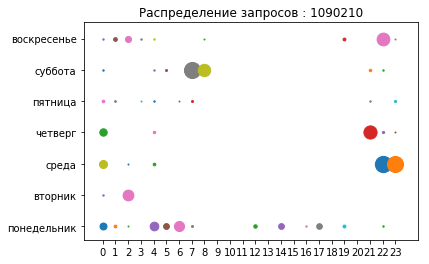

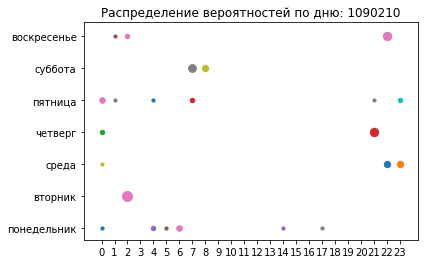

1 {0: 0.1, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.2, 5: 0.1, 6: 0.3, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.1, 15: 0.0, 16: 0.0, 17: 0.1, 18: 0.0, 19: 0.0, 20: 0.0, 21: 0.0, 22: 0.0, 23: 0.0}
2 {0: 0.0, 1: 0.0, 2: 1.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.0, 18: 0.0, 19: 0.0, 20: 0.0, 21: 0.0, 22: 0.0, 23: 0.0}
3 {0: 0.1, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.0, 18: 0.0, 19: 0.0, 20: 0.0, 21: 0.0, 22: 0.4, 23: 0.4}
4 {0: 0.2, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.0, 18: 0.0, 19: 0.0, 20: 0.0, 21: 0.7, 22: 0.0, 23: 0.0}
5 {0: 0.3, 1: 0.1, 2: 0.0, 3: 0.0, 4: 0.1, 5: 0.0, 6: 0.0, 7: 0.2, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.0, 18: 0.0, 

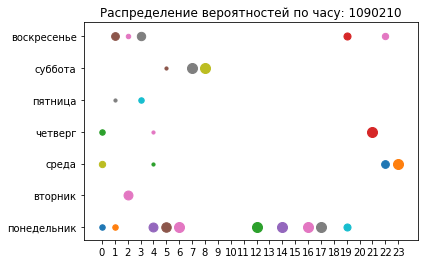

1 {0: 0.3, 1: 0.3, 2: 0.0, 3: 0.0, 4: 0.8, 5: 0.9, 6: 1.0, 7: 0.0, 8: 0.0, 9: 0, 10: 0, 11: 0, 12: 1.0, 13: 0, 14: 1.0, 15: 0, 16: 1.0, 17: 1.0, 18: 0, 19: 0.5, 20: 0, 21: 0.0, 22: 0.0, 23: 0.0}
2 {0: 0.0, 1: 0.0, 2: 0.8, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0, 10: 0, 11: 0, 12: 0.0, 13: 0, 14: 0.0, 15: 0, 16: 0.0, 17: 0.0, 18: 0, 19: 0.0, 20: 0, 21: 0.0, 22: 0.0, 23: 0.0}
3 {0: 0.4, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.1, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0, 10: 0, 11: 0, 12: 0.0, 13: 0, 14: 0.0, 15: 0, 16: 0.0, 17: 0.0, 18: 0, 19: 0.0, 20: 0, 21: 0.0, 22: 0.6, 23: 1.0}
4 {0: 0.3, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.1, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0, 10: 0, 11: 0, 12: 0.0, 13: 0, 14: 0.0, 15: 0, 16: 0.0, 17: 0.0, 18: 0, 19: 0.0, 20: 0, 21: 1.0, 22: 0.0, 23: 0.0}
5 {0: 0.0, 1: 0.1, 2: 0.0, 3: 0.3, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0, 10: 0, 11: 0, 12: 0.0, 13: 0, 14: 0.0, 15: 0, 16: 0.0, 17: 0.0, 18: 0, 19: 0.0, 20: 0, 21: 0.0, 22: 0.0, 23: 0.0}
6 {0: 0.0, 1: 0.0, 2: 0.0

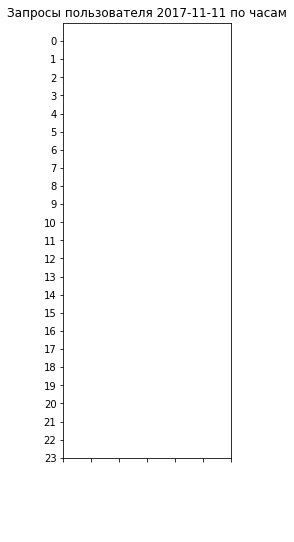

Board probability 0.2
Precision 0.0
Recall 0.0608695652174


2017-11-12

[*] Geting user daily statistics for user_id 1090210, date 2017-11-12.
[=] {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0}



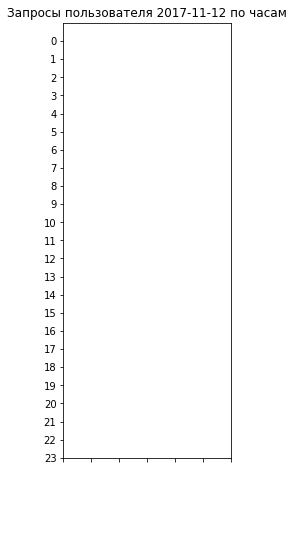

Board probability 0.2
Precision 0.0
Recall 0.0608695652174


2017-11-13

[*] Geting user daily statistics for user_id 1090210, date 2017-11-13.
[=] {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0}



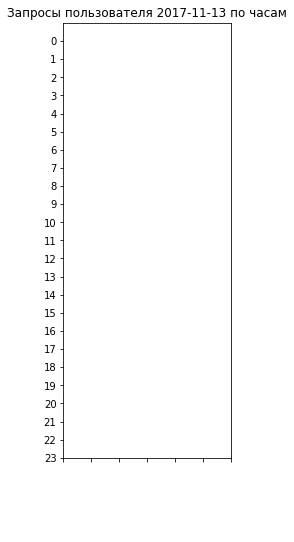

Board probability 0.2
Precision 0.0
Recall 0.0608695652174


2017-11-14

[*] Geting user daily statistics for user_id 1090210, date 2017-11-14.
[=] {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0}



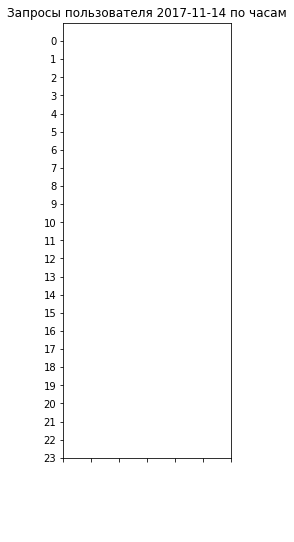

Board probability 0.2
Precision 0.0
Recall 0.0608695652174

==========================	Пользователь : 628739	==========================


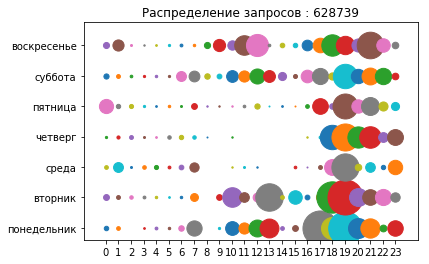

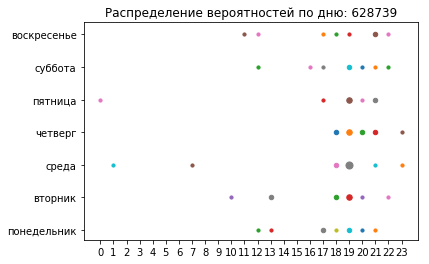

1 {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.1, 13: 0.1, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.2, 18: 0.1, 19: 0.2, 20: 0.1, 21: 0.1, 22: 0.0, 23: 0.0}
2 {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.1, 11: 0.0, 12: 0.0, 13: 0.2, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.0, 18: 0.2, 19: 0.3, 20: 0.1, 21: 0.0, 22: 0.1, 23: 0.0}
3 {0: 0.0, 1: 0.1, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.1, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.0, 18: 0.2, 19: 0.5, 20: 0.0, 21: 0.1, 22: 0.0, 23: 0.1}
4 {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.0, 18: 0.2, 19: 0.3, 20: 0.2, 21: 0.2, 22: 0.0, 23: 0.1}
5 {0: 0.1, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.1, 18: 0.0, 

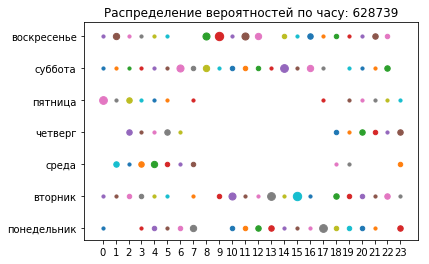

1 {0: 0.1, 1: 0.0, 2: 0.0, 3: 0.1, 4: 0.2, 5: 0.1, 6: 0.2, 7: 0.4, 8: 0.0, 9: 0.0, 10: 0.2, 11: 0.2, 12: 0.3, 13: 0.3, 14: 0.1, 15: 0.1, 16: 0.1, 17: 0.6, 18: 0.2, 19: 0.2, 20: 0.2, 21: 0.1, 22: 0.0, 23: 0.3}
2 {0: 0.1, 1: 0.1, 2: 0.2, 3: 0.2, 4: 0.1, 5: 0.1, 6: 0.0, 7: 0.1, 8: 0.0, 9: 0.2, 10: 0.5, 11: 0.1, 12: 0.1, 13: 0.6, 14: 0.1, 15: 0.7, 16: 0.1, 17: 0.0, 18: 0.3, 19: 0.2, 20: 0.2, 21: 0.1, 22: 0.3, 23: 0.1}
3 {0: 0.0, 1: 0.3, 2: 0.1, 3: 0.3, 4: 0.4, 5: 0.2, 6: 0.1, 7: 0.2, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.0, 18: 0.1, 19: 0.1, 20: 0.0, 21: 0.0, 22: 0.0, 23: 0.2}
4 {0: 0.0, 1: 0.0, 2: 0.3, 3: 0.1, 4: 0.1, 5: 0.3, 6: 0.1, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.0, 18: 0.2, 19: 0.1, 20: 0.3, 21: 0.2, 22: 0.1, 23: 0.3}
5 {0: 0.6, 1: 0.1, 2: 0.3, 3: 0.1, 4: 0.1, 5: 0.1, 6: 0.0, 7: 0.1, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.1, 18: 0.0, 

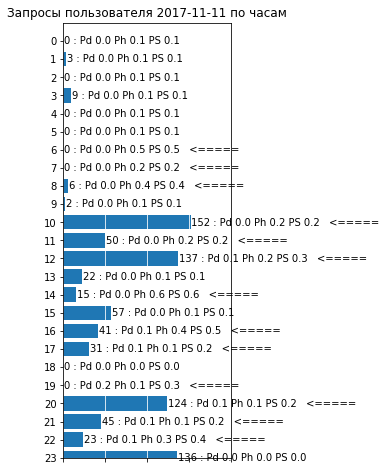

Board probability 0.2
Precision 0.0769230769231
Recall 0.0625


2017-11-12

[*] Geting user daily statistics for user_id 628739, date 2017-11-12.
[=] {0: 92, 1: 0, 2: 111, 3: 8, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 3, 11: 7, 12: 72, 13: 41, 14: 0, 15: 4, 16: 5, 17: 3, 18: 2, 19: 4, 20: 0, 21: 16, 22: 32, 23: 0}



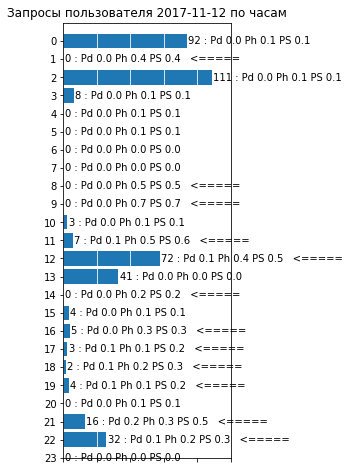

Board probability 0.2
Precision 0.072
Recall 0.06


2017-11-13

[*] Geting user daily statistics for user_id 628739, date 2017-11-13.
[=] {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 2, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 20, 18: 0, 19: 20, 20: 24, 21: 42, 22: 111, 23: 2}



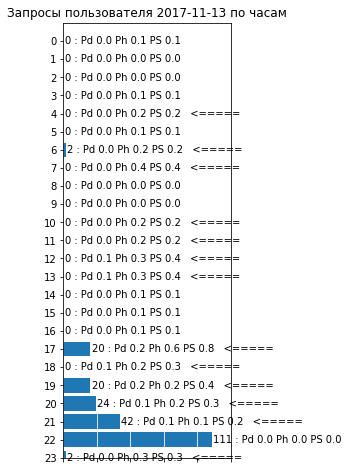

Board probability 0.2
Precision 0.0631578947368
Recall 0.0648648648649


2017-11-14

[*] Geting user daily statistics for user_id 628739, date 2017-11-14.
[=] {0: 39, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 12, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 1, 18: 88, 19: 72, 20: 1, 21: 26, 22: 2, 23: 1}



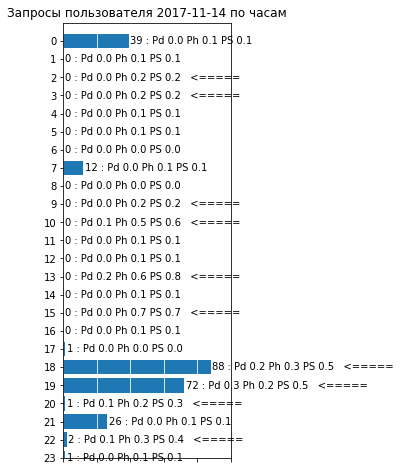

Board probability 0.2
Precision 0.0583333333333
Recall 0.0608695652174

==========================	Пользователь : 715663	==========================


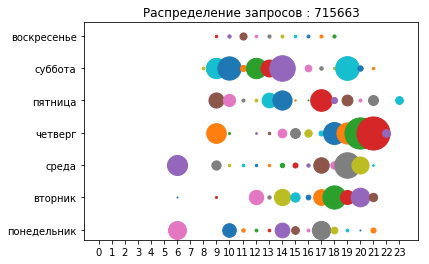

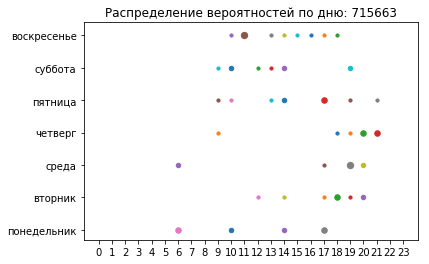

1 {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.3, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.2, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.2, 15: 0.0, 16: 0.0, 17: 0.3, 18: 0.0, 19: 0.0, 20: 0.0, 21: 0.0, 22: 0.0, 23: 0.0}
2 {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.1, 13: 0.0, 14: 0.1, 15: 0.0, 16: 0.0, 17: 0.1, 18: 0.3, 19: 0.1, 20: 0.2, 21: 0.0, 22: 0.0, 23: 0.0}
3 {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.2, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.1, 18: 0.0, 19: 0.4, 20: 0.2, 21: 0.0, 22: 0.0, 23: 0.0}
4 {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.1, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.0, 18: 0.1, 19: 0.1, 20: 0.3, 21: 0.3, 22: 0.0, 23: 0.0}
5 {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.1, 10: 0.1, 11: 0.0, 12: 0.0, 13: 0.1, 14: 0.2, 15: 0.0, 16: 0.0, 17: 0.3, 18: 0.0, 

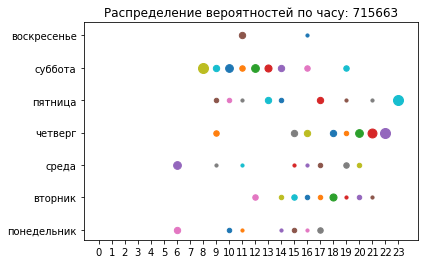

1 {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0.4, 7: 0, 8: 0.0, 9: 0.0, 10: 0.2, 11: 0.1, 12: 0.0, 13: 0.0, 14: 0.1, 15: 0.2, 16: 0.1, 17: 0.3, 18: 0.0, 19: 0.0, 20: 0.0, 21: 0.0, 22: 0.0, 23: 0.0}
2 {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0.0, 7: 0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.3, 13: 0.0, 14: 0.2, 15: 0.3, 16: 0.2, 17: 0.2, 18: 0.5, 19: 0.1, 20: 0.2, 21: 0.1, 22: 0.0, 23: 0.0}
3 {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0.6, 7: 0, 8: 0.0, 9: 0.1, 10: 0.0, 11: 0.1, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.1, 16: 0.1, 17: 0.2, 18: 0.0, 19: 0.3, 20: 0.2, 21: 0.0, 22: 0.0, 23: 0.0}
4 {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0.0, 7: 0, 8: 0.0, 9: 0.3, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.4, 16: 0.4, 17: 0.0, 18: 0.4, 19: 0.2, 20: 0.6, 21: 0.8, 22: 1.0, 23: 0.0}
5 {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0.0, 7: 0, 8: 0.0, 9: 0.2, 10: 0.2, 11: 0.1, 12: 0.0, 13: 0.4, 14: 0.2, 15: 0.0, 16: 0.0, 17: 0.4, 18: 0.0, 19: 0.1, 20: 0.0, 21: 0.1, 22: 0.0, 23: 1.0}
6 {0: 0, 1: 0, 2: 0, 3: 0

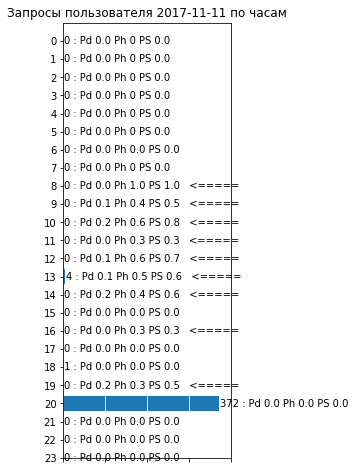

Board probability 0.2
Precision 0.0111111111111
Recall 0.0333333333333


2017-11-12

[*] Geting user daily statistics for user_id 715663, date 2017-11-12.
[=] {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0}



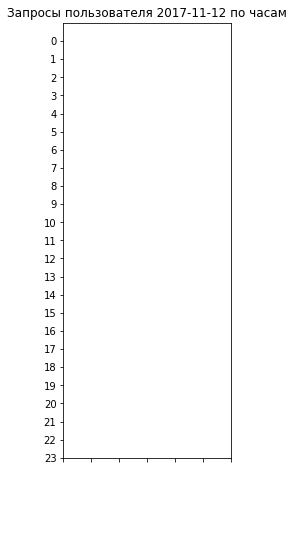

Board probability 0.2
Precision 0.00909090909091
Recall 0.0333333333333


2017-11-13

[*] Geting user daily statistics for user_id 715663, date 2017-11-13.
[=] {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 9, 11: 0, 12: 0, 13: 13, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 28, 20: 70, 21: 0, 22: 0, 23: 0}



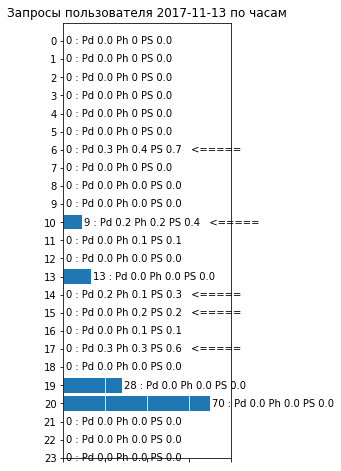

Board probability 0.2
Precision 0.0125
Recall 0.0285714285714


2017-11-14

[*] Geting user daily statistics for user_id 715663, date 2017-11-14.
[=] {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 140, 19: 149, 20: 0, 21: 0, 22: 0, 23: 0}



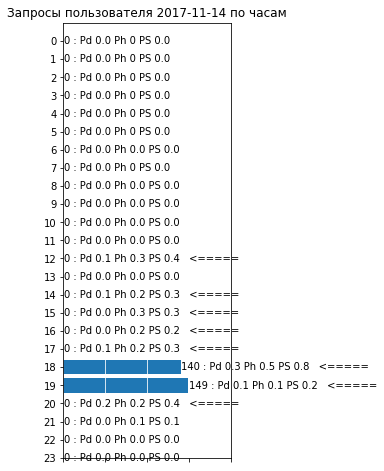

Board probability 0.2
Precision 0.0166666666667
Recall 0.0444444444444

==========================	Пользователь : 1068696	==========================


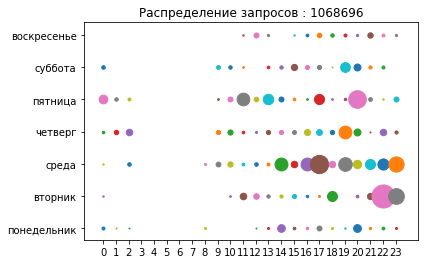

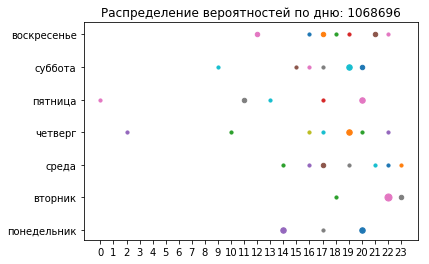

1 {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.3, 15: 0.0, 16: 0.0, 17: 0.1, 18: 0.0, 19: 0.0, 20: 0.3, 21: 0.0, 22: 0.0, 23: 0.0}
2 {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.0, 18: 0.1, 19: 0.0, 20: 0.0, 21: 0.0, 22: 0.5, 23: 0.2}
3 {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.1, 15: 0.0, 16: 0.1, 17: 0.2, 18: 0.0, 19: 0.1, 20: 0.0, 21: 0.1, 22: 0.1, 23: 0.1}
4 {0: 0.0, 1: 0.0, 2: 0.1, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.1, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.1, 17: 0.1, 18: 0.0, 19: 0.3, 20: 0.1, 21: 0.0, 22: 0.1, 23: 0.0}
5 {0: 0.1, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.2, 12: 0.0, 13: 0.1, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.1, 18: 0.0, 

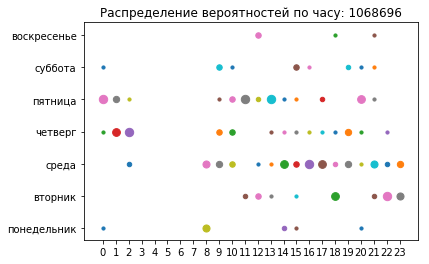

1 {0: 0.1, 1: 0.0, 2: 0.0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0.5, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.2, 15: 0.1, 16: 0.0, 17: 0.0, 18: 0.0, 19: 0.0, 20: 0.1, 21: 0.0, 22: 0.0, 23: 0.0}
2 {0: 0.0, 1: 0.0, 2: 0.0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.2, 12: 0.3, 13: 0.1, 14: 0.0, 15: 0.1, 16: 0.0, 17: 0.0, 18: 0.6, 19: 0.0, 20: 0.0, 21: 0.2, 22: 0.7, 23: 0.5}
3 {0: 0.0, 1: 0.0, 2: 0.2, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0.5, 9: 0.4, 10: 0.3, 11: 0.0, 12: 0.1, 13: 0.1, 14: 0.6, 15: 0.3, 16: 0.7, 17: 0.6, 18: 0.2, 19: 0.4, 20: 0.1, 21: 0.5, 22: 0.2, 23: 0.4}
4 {0: 0.1, 1: 0.6, 2: 0.7, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0.0, 9: 0.3, 10: 0.3, 11: 0.0, 12: 0.0, 13: 0.1, 14: 0.1, 15: 0.1, 16: 0.1, 17: 0.1, 18: 0.1, 19: 0.4, 20: 0.1, 21: 0.0, 22: 0.1, 23: 0.0}
5 {0: 0.7, 1: 0.4, 2: 0.1, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0.0, 9: 0.1, 10: 0.3, 11: 0.7, 12: 0.2, 13: 0.7, 14: 0.1, 15: 0.1, 16: 0.0, 17: 0.2, 18: 0.0, 19: 0.0, 20: 0.6, 21: 0.1, 22: 0.0, 23: 0.0}
6 {0:

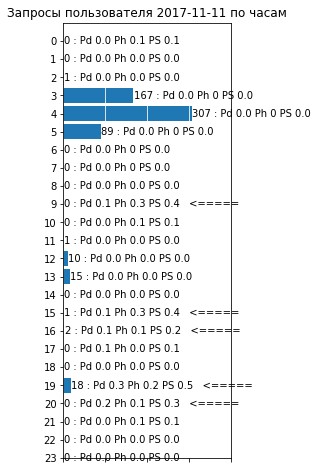

Board probability 0.2
Precision 0.06
Recall 0.03


2017-11-12

[*] Geting user daily statistics for user_id 1068696, date 2017-11-12.
[=] {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 21, 11: 0, 12: 3, 13: 0, 14: 6, 15: 3, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0}



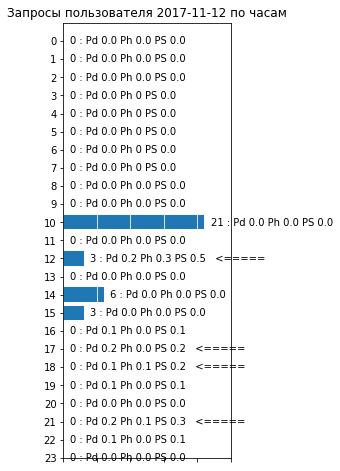

Board probability 0.2
Precision 0.0444444444444
Recall 0.0285714285714


2017-11-13

[*] Geting user daily statistics for user_id 1068696, date 2017-11-13.
[=] {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 10, 10: 6, 11: 9, 12: 4, 13: 1, 14: 1, 15: 0, 16: 16, 17: 14, 18: 4, 19: 0, 20: 0, 21: 0, 22: 3, 23: 0}



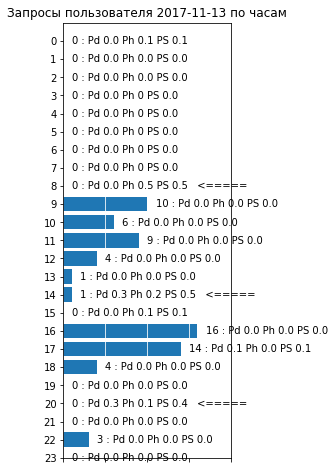

Board probability 0.2
Precision 0.0416666666667
Recall 0.0208333333333


2017-11-14

[*] Geting user daily statistics for user_id 1068696, date 2017-11-14.
[=] {0: 7, 1: 0, 2: 2, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 6, 13: 2, 14: 3, 15: 1, 16: 0, 17: 2, 18: 14, 19: 1, 20: 2, 21: 1, 22: 0, 23: 0}



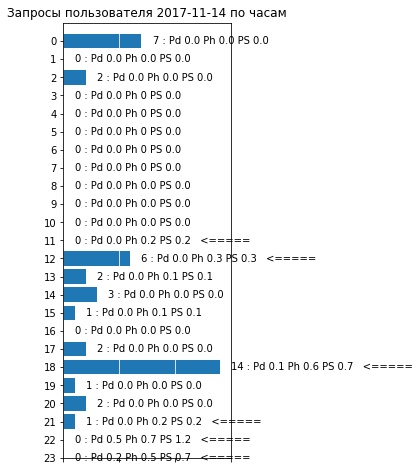

Board probability 0.2
Precision 0.0444444444444
Recall 0.0228571428571

==========================	Пользователь : 536449	==========================


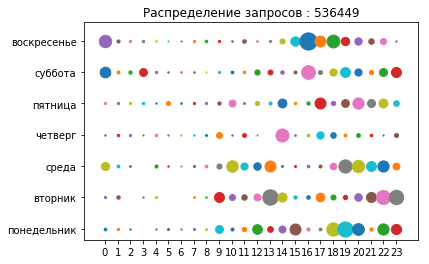

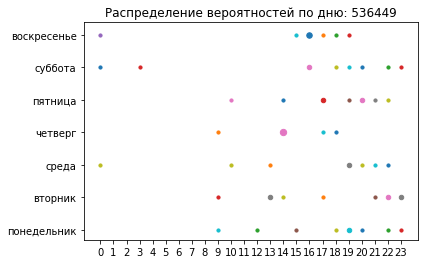

1 {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.1, 10: 0.0, 11: 0.0, 12: 0.1, 13: 0.0, 14: 0.0, 15: 0.1, 16: 0.0, 17: 0.0, 18: 0.1, 19: 0.2, 20: 0.1, 21: 0.0, 22: 0.1, 23: 0.1}
2 {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.1, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.2, 14: 0.1, 15: 0.0, 16: 0.0, 17: 0.1, 18: 0.0, 19: 0.0, 20: 0.0, 21: 0.1, 22: 0.2, 23: 0.2}
3 {0: 0.1, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.1, 11: 0.0, 12: 0.0, 13: 0.1, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.0, 18: 0.0, 19: 0.2, 20: 0.1, 21: 0.1, 22: 0.1, 23: 0.0}
4 {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.1, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.4, 15: 0.0, 16: 0.0, 17: 0.1, 18: 0.1, 19: 0.0, 20: 0.0, 21: 0.0, 22: 0.0, 23: 0.0}
5 {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.1, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.1, 15: 0.0, 16: 0.0, 17: 0.2, 18: 0.0, 

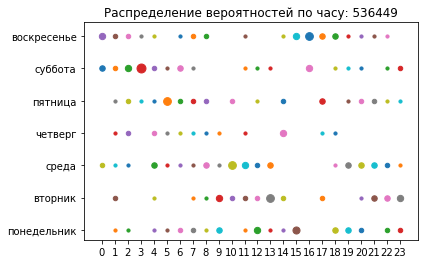

1 {0: 0.0, 1: 0.1, 2: 0.1, 3: 0.0, 4: 0.1, 5: 0.1, 6: 0.2, 7: 0.2, 8: 0.1, 9: 0.3, 10: 0.0, 11: 0.1, 12: 0.4, 13: 0.1, 14: 0.1, 15: 0.5, 16: 0.0, 17: 0.0, 18: 0.3, 19: 0.3, 20: 0.2, 21: 0.0, 22: 0.2, 23: 0.2}
2 {0: 0.0, 1: 0.2, 2: 0.0, 3: 0.0, 4: 0.1, 5: 0.0, 6: 0.0, 7: 0.1, 8: 0.1, 9: 0.4, 10: 0.2, 11: 0.2, 12: 0.2, 13: 0.6, 14: 0.2, 15: 0.0, 16: 0.0, 17: 0.2, 18: 0.0, 19: 0.0, 20: 0.1, 21: 0.3, 22: 0.3, 23: 0.4}
3 {0: 0.2, 1: 0.1, 2: 0.1, 3: 0.0, 4: 0.3, 5: 0.1, 6: 0.1, 7: 0.1, 8: 0.3, 9: 0.1, 10: 0.6, 11: 0.4, 12: 0.2, 13: 0.3, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.0, 18: 0.1, 19: 0.3, 20: 0.3, 21: 0.3, 22: 0.2, 23: 0.1}
4 {0: 0.0, 1: 0.1, 2: 0.2, 3: 0.0, 4: 0.2, 5: 0.1, 6: 0.1, 7: 0.1, 8: 0.1, 9: 0.1, 10: 0.0, 11: 0.1, 12: 0.0, 13: 0.0, 14: 0.4, 15: 0.0, 16: 0.0, 17: 0.1, 18: 0.1, 19: 0.0, 20: 0.0, 21: 0.0, 22: 0.0, 23: 0.0}
5 {0: 0.0, 1: 0.1, 2: 0.2, 3: 0.1, 4: 0.1, 5: 0.6, 6: 0.2, 7: 0.2, 8: 0.2, 9: 0.0, 10: 0.2, 11: 0.0, 12: 0.1, 13: 0.0, 14: 0.2, 15: 0.0, 16: 0.0, 17: 0.3, 18: 0.0, 

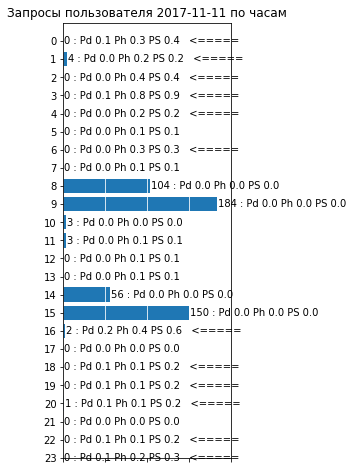

Board probability 0.2
Precision 0.025
Recall 0.0333333333333


2017-11-12

[*] Geting user daily statistics for user_id 536449, date 2017-11-12.
[=] {0: 5, 1: 153, 2: 254, 3: 51, 4: 0, 5: 0, 6: 2, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 8, 13: 166, 14: 283, 15: 367, 16: 2, 17: 0, 18: 41, 19: 466, 20: 489, 21: 379, 22: 231, 23: 78}



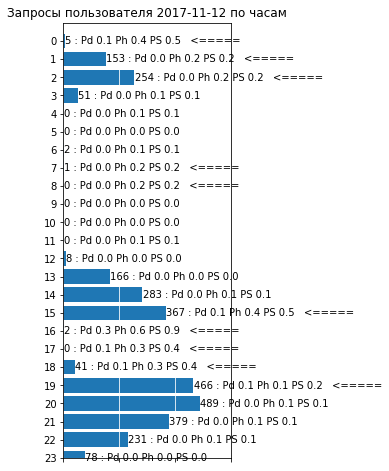

Board probability 0.2
Precision 0.05
Recall 0.0423076923077


2017-11-13

[*] Geting user daily statistics for user_id 536449, date 2017-11-13.
[=] {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 3, 9: 57, 10: 1, 11: 12, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 2, 18: 0, 19: 0, 20: 0, 21: 119, 22: 297, 23: 238}



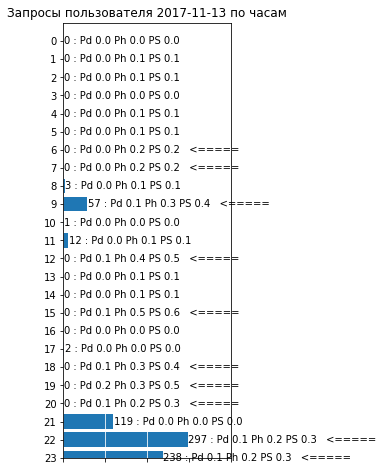

Board probability 0.2
Precision 0.04375
Recall 0.0411764705882


2017-11-14

[*] Geting user daily statistics for user_id 536449, date 2017-11-14.
[=] {0: 15, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 7, 7: 1, 8: 0, 9: 10, 10: 20, 11: 4, 12: 0, 13: 52, 14: 17, 15: 0, 16: 35, 17: 21, 18: 205, 19: 298, 20: 274, 21: 245, 22: 225, 23: 11}



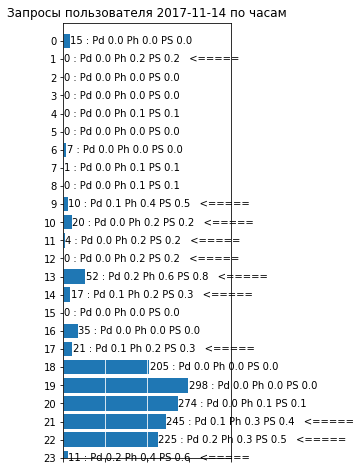

Board probability 0.2
Precision 0.053488372093
Recall 0.046

==========================	Пользователь : 1260820	==========================


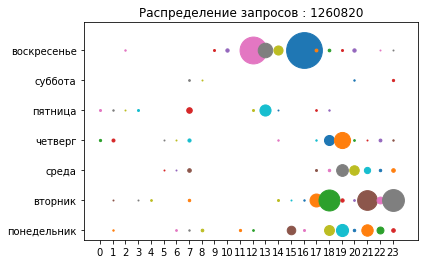

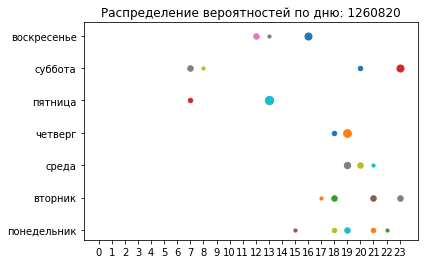

1 {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.1, 16: 0.0, 17: 0.0, 18: 0.2, 19: 0.3, 20: 0.0, 21: 0.2, 22: 0.1, 23: 0.0}
2 {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.1, 18: 0.3, 19: 0.0, 20: 0.0, 21: 0.3, 22: 0.0, 23: 0.3}
3 {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.0, 18: 0.0, 19: 0.4, 20: 0.3, 21: 0.1, 22: 0.0, 23: 0.0}
4 {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.0, 18: 0.2, 19: 0.6, 20: 0.0, 21: 0.0, 22: 0.0, 23: 0.0}
5 {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.2, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.7, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.0, 18: 0.0, 

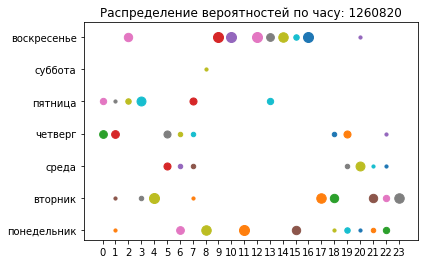

1 {0: 0.0, 1: 0.1, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.6, 7: 0.0, 8: 0.9, 9: 0.0, 10: 0.0, 11: 1.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.7, 16: 0.0, 17: 0.0, 18: 0.1, 19: 0.3, 20: 0.1, 21: 0.2, 22: 0.4, 23: 0.0}
2 {0: 0.0, 1: 0.1, 2: 0.0, 3: 0.2, 4: 1.0, 5: 0.0, 6: 0.0, 7: 0.1, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.9, 18: 0.7, 19: 0.0, 20: 0.0, 21: 0.7, 22: 0.4, 23: 0.9}
3 {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.5, 6: 0.2, 7: 0.2, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.0, 18: 0.0, 19: 0.2, 20: 0.8, 21: 0.1, 22: 0.1, 23: 0.0}
4 {0: 0.6, 1: 0.6, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.5, 6: 0.2, 7: 0.2, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.0, 18: 0.2, 19: 0.5, 20: 0.0, 21: 0.0, 22: 0.1, 23: 0.0}
5 {0: 0.4, 1: 0.1, 2: 0.3, 3: 0.8, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.5, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.4, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.0, 18: 0.0, 

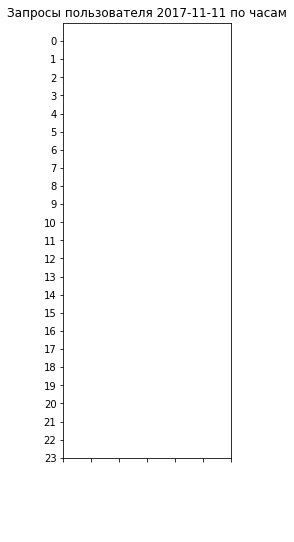

Board probability 0.2
Precision 0.0
Recall 0.046


2017-11-12

[*] Geting user daily statistics for user_id 1260820, date 2017-11-12.
[=] {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 9, 22: 6, 23: 10}



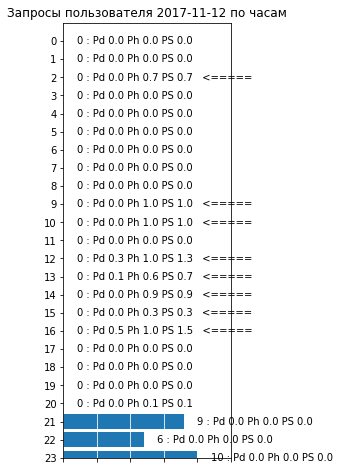

Board probability 0.2
Precision 0.0
Recall 0.0


2017-11-13

[*] Geting user daily statistics for user_id 1260820, date 2017-11-13.
[=] {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 31, 16: 0, 17: 1, 18: 0, 19: 19, 20: 19, 21: 0, 22: 1, 23: 0}



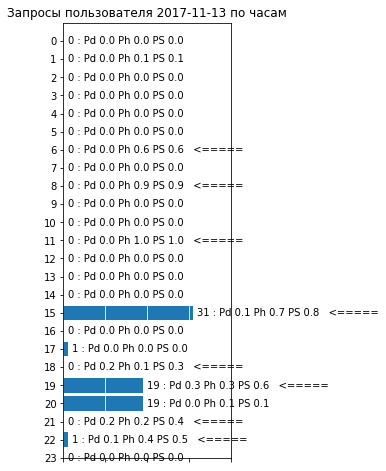

Board probability 0.2
Precision 0.015
Recall 0.0375


2017-11-14

[*] Geting user daily statistics for user_id 1260820, date 2017-11-14.
[=] {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 3, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 2, 21: 20, 22: 0, 23: 2}



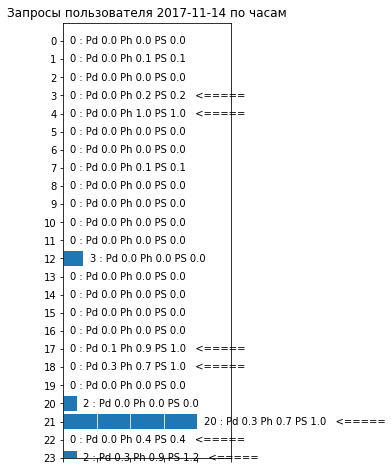

Board probability 0.2
Precision 0.0185185185185
Recall 0.0416666666667

==========================	Пользователь : 9195742	==========================


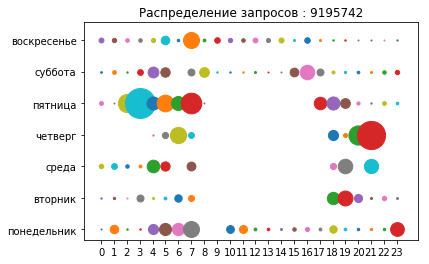

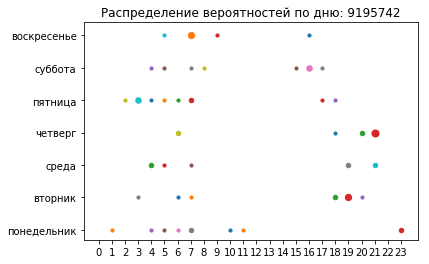

1 {0: 0.0, 1: 0.1, 2: 0.0, 3: 0.0, 4: 0.1, 5: 0.1, 6: 0.1, 7: 0.2, 8: 0.0, 9: 0.0, 10: 0.1, 11: 0.1, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.0, 18: 0.0, 19: 0.0, 20: 0.0, 21: 0.0, 22: 0.0, 23: 0.2}
2 {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.1, 4: 0.0, 5: 0.0, 6: 0.1, 7: 0.1, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.0, 18: 0.2, 19: 0.4, 20: 0.1, 21: 0.0, 22: 0.0, 23: 0.0}
3 {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.2, 5: 0.1, 6: 0.0, 7: 0.1, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.0, 18: 0.0, 19: 0.2, 20: 0.0, 21: 0.2, 22: 0.0, 23: 0.0}
4 {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.2, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.0, 18: 0.1, 19: 0.0, 20: 0.2, 21: 0.5, 22: 0.0, 23: 0.0}
5 {0: 0.0, 1: 0.0, 2: 0.1, 3: 0.3, 4: 0.1, 5: 0.1, 6: 0.1, 7: 0.2, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.1, 18: 0.1, 

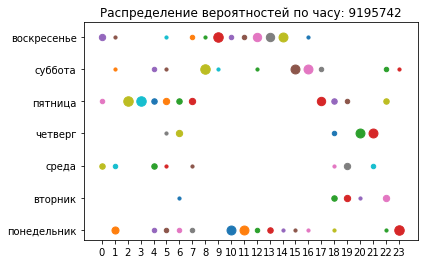

1 {0: 0.0, 1: 0.5, 2: 0.0, 3: 0.0, 4: 0.2, 5: 0.2, 6: 0.2, 7: 0.2, 8: 0.0, 9: 0.0, 10: 0.8, 11: 0.8, 12: 0.2, 13: 0.3, 14: 0.1, 15: 0.1, 16: 0.1, 17: 0.0, 18: 0.1, 19: 0.0, 20: 0.0, 21: 0.0, 22: 0.1, 23: 0.9}
2 {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.1, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.0, 18: 0.3, 19: 0.4, 20: 0.1, 21: 0.0, 22: 0.4, 23: 0.0}
3 {0: 0.3, 1: 0.2, 2: 0.0, 3: 0.0, 4: 0.3, 5: 0.1, 6: 0.0, 7: 0.1, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.0, 18: 0.1, 19: 0.4, 20: 0.0, 21: 0.2, 22: 0.0, 23: 0.0}
4 {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.1, 6: 0.4, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.0, 18: 0.2, 19: 0.0, 20: 0.8, 21: 0.8, 22: 0.0, 23: 0.0}
5 {0: 0.2, 1: 0.0, 2: 0.9, 3: 0.9, 4: 0.3, 5: 0.4, 6: 0.3, 7: 0.4, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.7, 18: 0.3, 

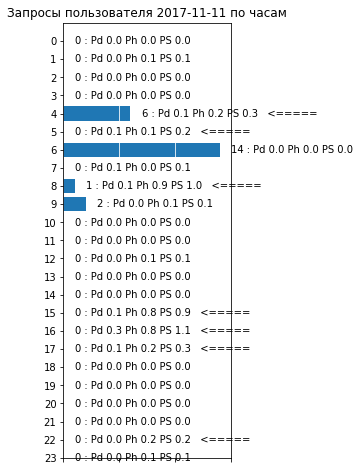

Board probability 0.2
Precision 0.0285714285714
Recall 0.05


2017-11-12

[*] Geting user daily statistics for user_id 9195742, date 2017-11-12.
[=] {0: 20, 1: 0, 2: 0, 3: 0, 4: 64, 5: 10, 6: 1, 7: 36, 8: 0, 9: 83, 10: 424, 11: 0, 12: 15, 13: 0, 14: 0, 15: 1, 16: 0, 17: 6, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0}



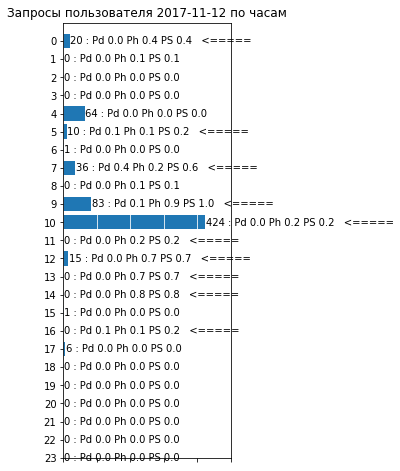

Board probability 0.2
Precision 0.0470588235294
Recall 0.0571428571429


2017-11-13

[*] Geting user daily statistics for user_id 9195742, date 2017-11-13.
[=] {0: 0, 1: 0, 2: 0, 3: 0, 4: 111, 5: 72, 6: 0, 7: 16, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0}



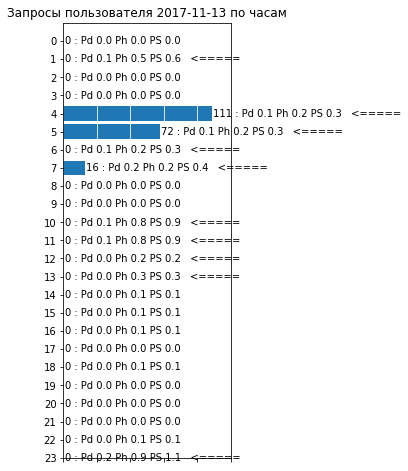

Board probability 0.2
Precision 0.0407407407407
Recall 0.0647058823529


2017-11-14

[*] Geting user daily statistics for user_id 9195742, date 2017-11-14.
[=] {0: 0, 1: 0, 2: 0, 3: 0, 4: 21, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0}



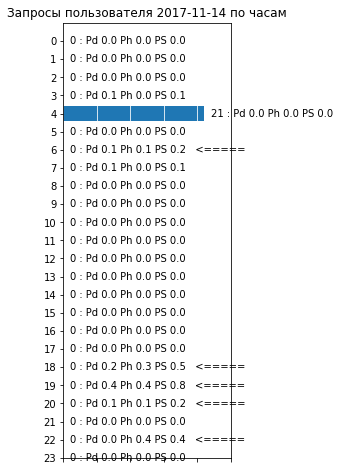

Board probability 0.2
Precision 0.034375
Recall 0.0611111111111

==========================	Пользователь : 127345	==========================


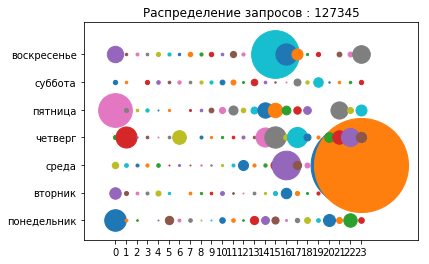

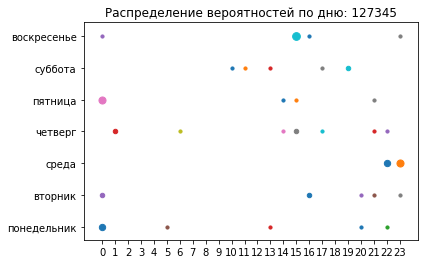

1 {0: 0.4, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.1, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.1, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.0, 18: 0.0, 19: 0.0, 20: 0.1, 21: 0.0, 22: 0.1, 23: 0.0}
2 {0: 0.2, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.2, 17: 0.0, 18: 0.0, 19: 0.0, 20: 0.1, 21: 0.1, 22: 0.0, 23: 0.1}
3 {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.0, 18: 0.0, 19: 0.0, 20: 0.0, 21: 0.0, 22: 0.4, 23: 0.5}
4 {0: 0.0, 1: 0.2, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.1, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.1, 15: 0.2, 16: 0.0, 17: 0.1, 18: 0.0, 19: 0.0, 20: 0.0, 21: 0.1, 22: 0.1, 23: 0.0}
5 {0: 0.5, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.1, 15: 0.1, 16: 0.0, 17: 0.0, 18: 0.0, 

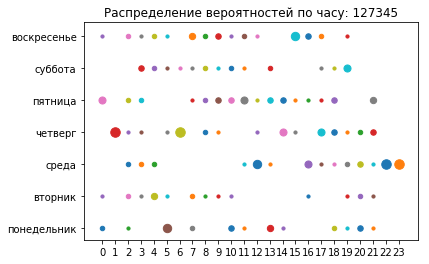

1 {0: 0.2, 1: 0.0, 2: 0.1, 3: 0.0, 4: 0.0, 5: 0.7, 6: 0.0, 7: 0.2, 8: 0.0, 9: 0.0, 10: 0.3, 11: 0.1, 12: 0.0, 13: 0.4, 14: 0.1, 15: 0.0, 16: 0.0, 17: 0.0, 18: 0.2, 19: 0.1, 20: 0.3, 21: 0.1, 22: 0.0, 23: 0.0}
2 {0: 0.1, 1: 0.0, 2: 0.2, 3: 0.1, 4: 0.4, 5: 0.1, 6: 0.0, 7: 0.2, 8: 0.1, 9: 0.1, 10: 0.1, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.1, 17: 0.0, 18: 0.0, 19: 0.1, 20: 0.2, 21: 0.1, 22: 0.0, 23: 0.0}
3 {0: 0.0, 1: 0.0, 2: 0.2, 3: 0.2, 4: 0.2, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.1, 12: 0.7, 13: 0.1, 14: 0.0, 15: 0.0, 16: 0.5, 17: 0.1, 18: 0.1, 19: 0.2, 20: 0.3, 21: 0.1, 22: 0.9, 23: 0.9}
4 {0: 0.0, 1: 0.9, 2: 0.1, 3: 0.1, 4: 0.0, 5: 0.1, 6: 0.9, 7: 0.0, 8: 0.2, 9: 0.1, 10: 0.0, 11: 0.0, 12: 0.1, 13: 0.0, 14: 0.5, 15: 0.1, 16: 0.0, 17: 0.5, 18: 0.3, 19: 0.1, 20: 0.2, 21: 0.3, 22: 0.0, 23: 0.0}
5 {0: 0.5, 1: 0.0, 2: 0.2, 3: 0.2, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.1, 8: 0.2, 9: 0.3, 10: 0.3, 11: 0.5, 12: 0.1, 13: 0.3, 14: 0.3, 15: 0.1, 16: 0.1, 17: 0.1, 18: 0.3, 

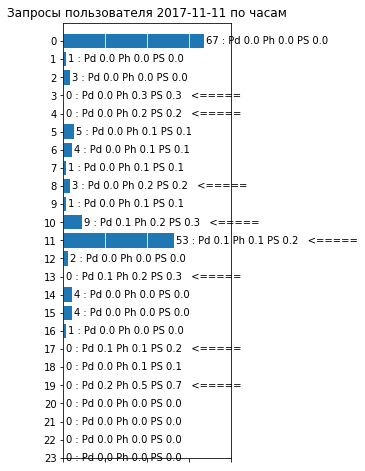

Board probability 0.2
Precision 0.0375
Recall 0.0214285714286


2017-11-12

[*] Geting user daily statistics for user_id 127345, date 2017-11-12.
[=] {0: 0, 1: 0, 2: 0, 3: 0, 4: 3, 5: 0, 6: 0, 7: 0, 8: 0, 9: 7, 10: 0, 11: 4, 12: 18, 13: 1, 14: 13, 15: 74, 16: 0, 17: 7, 18: 112, 19: 20, 20: 10, 21: 0, 22: 24, 23: 4}



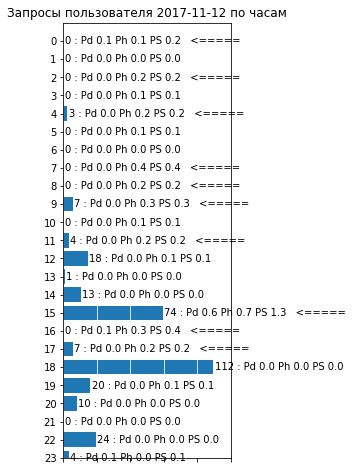

Board probability 0.2
Precision 0.0444444444444
Recall 0.0296296296296


2017-11-13

[*] Geting user daily statistics for user_id 127345, date 2017-11-13.
[=] {0: 11, 1: 73, 2: 2, 3: 0, 4: 2, 5: 0, 6: 0, 7: 0, 8: 1, 9: 1, 10: 155, 11: 5, 12: 4, 13: 2, 14: 2, 15: 37, 16: 32, 17: 2, 18: 7, 19: 18, 20: 37, 21: 38, 22: 1, 23: 5}



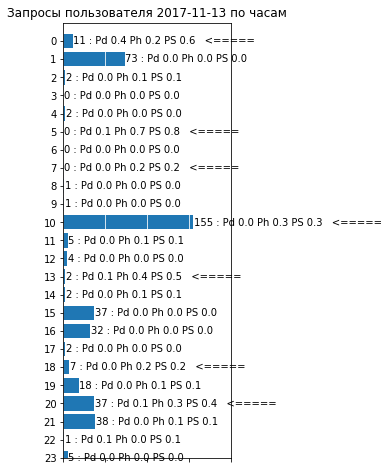

Board probability 0.2
Precision 0.052
Recall 0.0276595744681


2017-11-14

[*] Geting user daily statistics for user_id 127345, date 2017-11-14.
[=] {0: 2, 1: 3, 2: 1, 3: 0, 4: 2, 5: 2, 6: 1, 7: 0, 8: 3, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 3, 15: 4, 16: 287, 17: 4, 18: 6, 19: 6, 20: 25, 21: 38, 22: 3, 23: 17}



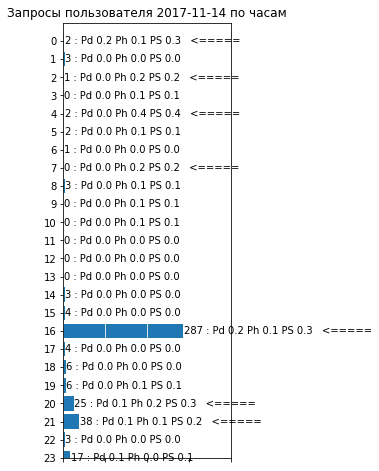

Board probability 0.2
Precision 0.059375
Recall 0.0296875

==========================	Пользователь : 2624641	==========================


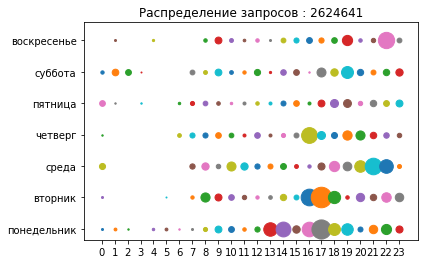

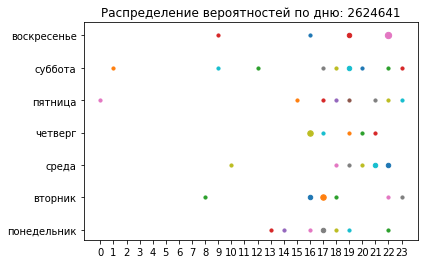

1 {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.1, 14: 0.1, 15: 0.0, 16: 0.1, 17: 0.2, 18: 0.1, 19: 0.1, 20: 0.0, 21: 0.0, 22: 0.1, 23: 0.0}
2 {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.1, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.2, 17: 0.3, 18: 0.1, 19: 0.0, 20: 0.0, 21: 0.0, 22: 0.1, 23: 0.1}
3 {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.1, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.0, 18: 0.1, 19: 0.1, 20: 0.1, 21: 0.2, 22: 0.2, 23: 0.0}
4 {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.3, 17: 0.1, 18: 0.0, 19: 0.1, 20: 0.1, 21: 0.1, 22: 0.0, 23: 0.0}
5 {0: 0.1, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.1, 16: 0.0, 17: 0.1, 18: 0.1, 

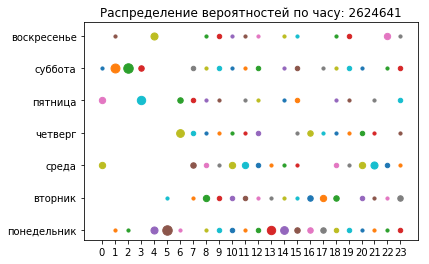

1 {0: 0.0, 1: 0.1, 2: 0.1, 3: 0.0, 4: 0.5, 5: 0.9, 6: 0.1, 7: 0.0, 8: 0.1, 9: 0.2, 10: 0.2, 11: 0.1, 12: 0.2, 13: 0.7, 14: 0.6, 15: 0.3, 16: 0.3, 17: 0.3, 18: 0.2, 19: 0.2, 20: 0.1, 21: 0.1, 22: 0.1, 23: 0.2}
2 {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.1, 6: 0.0, 7: 0.1, 8: 0.4, 9: 0.2, 10: 0.2, 11: 0.2, 12: 0.1, 13: 0.1, 14: 0.1, 15: 0.1, 16: 0.3, 17: 0.4, 18: 0.3, 19: 0.0, 20: 0.2, 21: 0.1, 22: 0.1, 23: 0.3}
3 {0: 0.4, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.3, 8: 0.2, 9: 0.1, 10: 0.4, 11: 0.4, 12: 0.2, 13: 0.1, 14: 0.1, 15: 0.1, 16: 0.0, 17: 0.0, 18: 0.2, 19: 0.1, 20: 0.4, 21: 0.5, 22: 0.2, 23: 0.1}
4 {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.6, 7: 0.2, 8: 0.1, 9: 0.1, 10: 0.1, 11: 0.1, 12: 0.2, 13: 0.0, 14: 0.0, 15: 0.1, 16: 0.3, 17: 0.1, 18: 0.1, 19: 0.1, 20: 0.2, 21: 0.1, 22: 0.0, 23: 0.1}
5 {0: 0.4, 1: 0.0, 2: 0.0, 3: 0.7, 4: 0.0, 5: 0.0, 6: 0.3, 7: 0.2, 8: 0.1, 9: 0.1, 10: 0.0, 11: 0.1, 12: 0.1, 13: 0.0, 14: 0.1, 15: 0.2, 16: 0.0, 17: 0.0, 18: 0.1, 

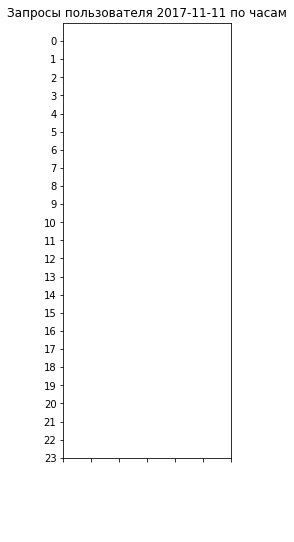

Board probability 0.2
Precision 0.0
Recall 0.0296875


2017-11-12

[*] Geting user daily statistics for user_id 2624641, date 2017-11-12.
[=] {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0}



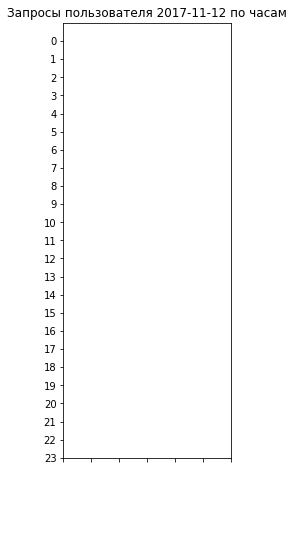

Board probability 0.2
Precision 0.0
Recall 0.0296875


2017-11-13

[*] Geting user daily statistics for user_id 2624641, date 2017-11-13.
[=] {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0}



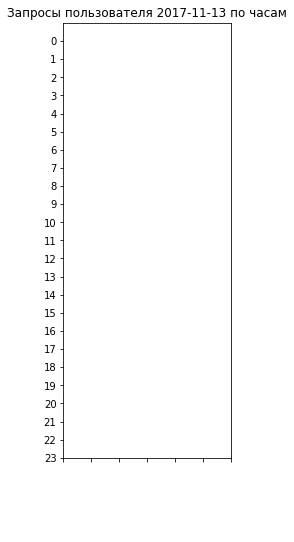

Board probability 0.2
Precision 0.0
Recall 0.0296875


2017-11-14

[*] Geting user daily statistics for user_id 2624641, date 2017-11-14.
[=] {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0}



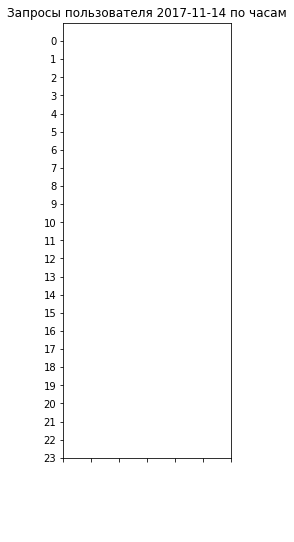

Board probability 0.2
Precision 0.0
Recall 0.0296875

==========================	Пользователь : 695698	==========================


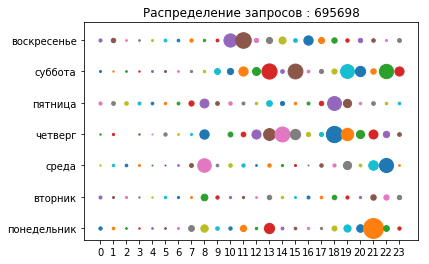

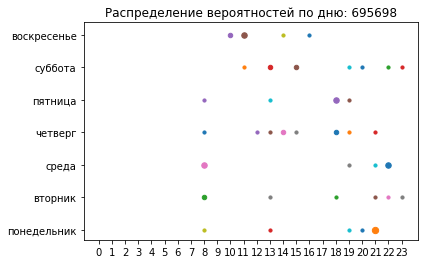

1 {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.1, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.1, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.0, 18: 0.0, 19: 0.1, 20: 0.1, 21: 0.4, 22: 0.0, 23: 0.0}
2 {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.2, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.1, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.0, 18: 0.1, 19: 0.0, 20: 0.0, 21: 0.1, 22: 0.1, 23: 0.1}
3 {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.3, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.0, 18: 0.0, 19: 0.1, 20: 0.0, 21: 0.1, 22: 0.3, 23: 0.0}
4 {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.1, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.1, 13: 0.1, 14: 0.2, 15: 0.1, 16: 0.0, 17: 0.0, 18: 0.2, 19: 0.1, 20: 0.0, 21: 0.1, 22: 0.0, 23: 0.0}
5 {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.1, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.1, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.0, 18: 0.3, 

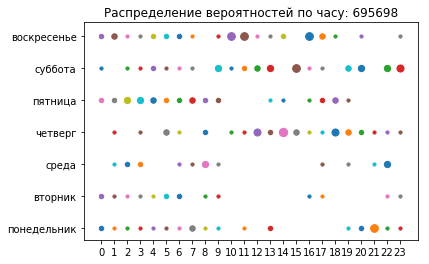

1 {0: 0.2, 1: 0.1, 2: 0.1, 3: 0.1, 4: 0.1, 5: 0.1, 6: 0.1, 7: 0.3, 8: 0.1, 9: 0.1, 10: 0.0, 11: 0.1, 12: 0.0, 13: 0.2, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.0, 18: 0.0, 19: 0.1, 20: 0.2, 21: 0.6, 22: 0.1, 23: 0.1}
2 {0: 0.2, 1: 0.1, 2: 0.1, 3: 0.1, 4: 0.1, 5: 0.2, 6: 0.2, 7: 0.0, 8: 0.1, 9: 0.1, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.1, 17: 0.1, 18: 0.0, 19: 0.0, 20: 0.0, 21: 0.0, 22: 0.1, 23: 0.1}
3 {0: 0.0, 1: 0.1, 2: 0.2, 3: 0.2, 4: 0.0, 5: 0.0, 6: 0.1, 7: 0.1, 8: 0.4, 9: 0.1, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.1, 18: 0.0, 19: 0.1, 20: 0.0, 21: 0.1, 22: 0.4, 23: 0.0}
4 {0: 0.0, 1: 0.1, 2: 0.0, 3: 0.1, 4: 0.0, 5: 0.3, 6: 0.1, 7: 0.0, 8: 0.2, 9: 0.0, 10: 0.1, 11: 0.1, 12: 0.5, 13: 0.2, 14: 0.7, 15: 0.3, 16: 0.1, 17: 0.1, 18: 0.5, 19: 0.3, 20: 0.2, 21: 0.1, 22: 0.1, 23: 0.1}
5 {0: 0.2, 1: 0.2, 2: 0.4, 3: 0.4, 4: 0.3, 5: 0.2, 6: 0.2, 7: 0.3, 8: 0.2, 9: 0.2, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.1, 14: 0.1, 15: 0.0, 16: 0.1, 17: 0.2, 18: 0.3, 

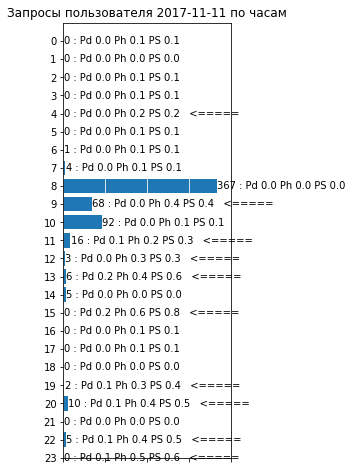

Board probability 0.2
Precision 0.07
Recall 0.0583333333333


2017-11-12

[*] Geting user daily statistics for user_id 695698, date 2017-11-12.
[=] {0: 4, 1: 5, 2: 1, 3: 2, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 4, 10: 29, 11: 3, 12: 0, 13: 0, 14: 2, 15: 3, 16: 0, 17: 6, 18: 24, 19: 8, 20: 27, 21: 0, 22: 0, 23: 8}



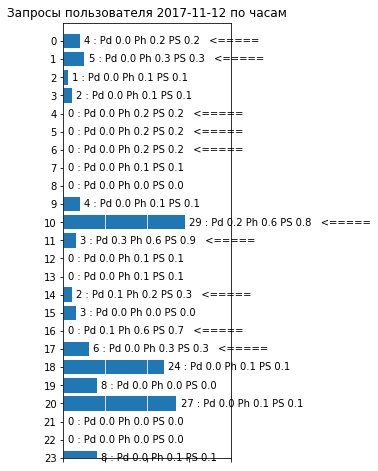

Board probability 0.2
Precision 0.065
Recall 0.05


2017-11-13

[*] Geting user daily statistics for user_id 695698, date 2017-11-13.
[=] {0: 6, 1: 2, 2: 1, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 2, 9: 1, 10: 4, 11: 0, 12: 1, 13: 1, 14: 3, 15: 2, 16: 3, 17: 0, 18: 1, 19: 5, 20: 1, 21: 8, 22: 11, 23: 4}



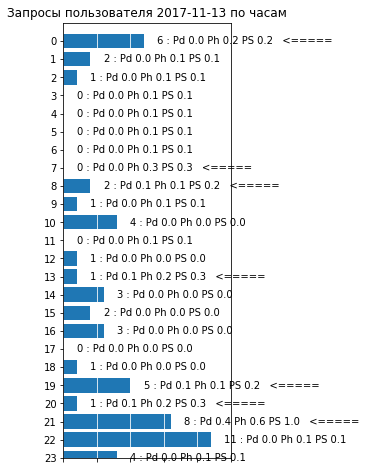

Board probability 0.2
Precision 0.0703703703704
Recall 0.0441860465116


2017-11-14

[*] Geting user daily statistics for user_id 695698, date 2017-11-14.
[=] {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 8: 31, 9: 0, 10: 0, 11: 1, 12: 1, 13: 0, 14: 7, 15: 0, 16: 0, 17: 2, 18: 15, 19: 0, 20: 13, 21: 28, 22: 2, 23: 1}



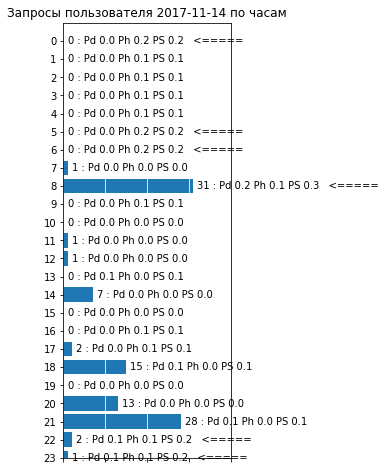

Board probability 0.2
Precision 0.0666666666667
Recall 0.0407407407407



In [150]:
def print_user_prob(user_prob):
    for day, prob in user_prob.iteritems():
        print day, prob

def doit(user, user_stat):
    show_diag(user, user_stat, u'Распределение запросов : ')

    user_prob_day = get_probability_by_day(user, user_stat)
    show_diag(user, user_prob_day, u'Распределение вероятностей по дню: ', coeff = 100)
    print_user_prob(user_prob_day)
    
    user_prob_hour = get_probability_by_hour(user, user_stat)
    show_diag(user, user_prob_hour, u'Распределение вероятностей по часу: ', coeff = 100)
    print_user_prob(user_prob_hour)

    return user_prob_day, user_prob_hour

data = get_users_statistics('./users_statistics')

for user, user_stat in data.items()[3] #    if user == '1068696': # 
#for user, user_stat in data.items()[1] #    if user == '628739': # 
#for user, user_stat in data.items()[8] #    if user == '2624641': # 
#for user, user_stat in data.iteritems():
    print(u"==========================\tПользователь : %s\t==========================" % user)
    user_prob_day, user_prob_hour = doit(user, user_stat)

    evaluation_param = [0, 0, 0, 0]

    for date in generate_datelist(2017, 11, 11, 15):
        print ("\n%s\n" % date)
        
        user_daily_statistics = get_user_daily_statistics(user, date)
        broad = 0.2
        show_daily_diag(user_daily_statistics, date, user_prob_day, user_prob_hour, broad)
    #    fp_, tp_, tn_, fn_ = evaluation(user_daily_statistics, date, user_prob_day, user_prob_hour, broad)
        param_ = evaluation(user_daily_statistics, date, user_prob_day, user_prob_hour, broad)
        evaluation_param = map( lambda x,y: x+y, evaluation_param, param_)
    
    #precision = tp * 0.1 / (tp + fp)
    #recall = tp * 0.1 / (tp + fn)
        try:
            precision = evaluation_param[1] * 0.1 / (evaluation_param[1] + evaluation_param[0])
        except ZeroDivisionError:
            precision = float(0)
        try:
            recall = evaluation_param[1] * 0.1 / (evaluation_param[1] + evaluation_param[3])
        except ZeroDivisionError:
            precision = float(0)
        print "Board probability {}\nPrecision {}\nRecall {}\n".format(broad, precision, recall)
